## Import Modules

In [1]:
import cv2
import json
import numpy as np
import os
import socket
import time
from IPython.display import display
from PIL import Image
from matplotlib import pyplot as plt
from pathlib import Path
from rich import inspect

# from torch.utils.tensorboard import SummaryWriter
import torch
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# rcg
from config import RCGConfiguration
from pixel_generator.mage import models_mage
from rdm.util import instantiate_from_config

%matplotlib inline


In [2]:
# rtk
from rtk._datasets import cxr14, create_transforms
from rtk.config import *
from rtk.mlflow import prepare_mlflow
from rtk.repl import prepare_console
from rtk.utils import get_logger, hydra_instantiate, _strip_target

ws, console = prepare_console(show_locals=False)

In [3]:
def viz_torchimage(image):
    image = torch.clamp(image, 0, 1)
    image_np = image.detach().cpu().numpy().transpose([1, 2, 0])
    image_np = Image.fromarray(np.uint8(image_np*255))
    display(image_np)

In [4]:
init_method_kwargs = {"config_dir": "/home/nicoleg/workspaces/rcg/config/"}
config_name = "rdm"

In [5]:
args: RCGConfiguration = set_hydra_configuration(
    config_name,
    ConfigurationInstance=RCGConfiguration,
    init_method_kwargs=init_method_kwargs,
)
console.print(args)

[23:03:58] INFO     rtk.config: Creating configuration: 'rdm'                                         ]8;id=307565;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/config.py\config.py]8;;\:]8;id=39273;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/config.py#129\129]8;;\
                    [0m                                                                                            

RCGConfiguration(
    datasets={'name': 'cxr14', 'dim': 256, 'extension': '.png', 'index': 'Image Index', 'labels': None, 'target': 
'class_conditioned_labels', 'patient_data': 'cxr14_metadata', 'patient_data_version': 2, 'scan_data': 
'/home/nicoleg/workspaces/dissertation/.data/CHEST_XRAY_14/', 'dataloader': {'_target_': 
'monai.data.ThreadDataLoader', 'batch_size': 8, 'num_workers': 24}, 'instantiate': {'_target_': 
'monai.data.ImageDataset'}, 'keys': {'image_files': 'image_files', 'labels': 'labels'}, 'encoding': {'No Finding': 
0, 'Pneumonia (m)': 1, 'Pneumonia (s)': 2, 'Other': 3}, 'preprocessing': {'labels': None, 'positive_class': 
'Pneumonia (m)', 'use_sampling': False, 'sampling_method': {'sample_to_value': 3500, 'method': {'_target_': 
None}}}, 'transforms': {'load': [{'_target_': 'monai.transforms.EnsureChannelFirst'}, {'_target_': 
'monai.transforms.Resize', 'spatial_size': ['${datasets.dim}', '${datasets.dim}']}], 'train': [{'_target_': 
'torchvision.transforms.RandomCrop', 'size': '${datasets.dim}'}, {'_target_': 
'torchvision.transforms.RandomHorizontalFlip'}]}},
    mlflow={'experiment_name': 'rcg-experiments', 'start_run': {'experiment_id': None, 'run_name': 
'rdm-${now:%Y-%m-%d-%H-%M-%S}', 'log_system_metrics': True}},
    date='2024-02-05',
    postfix='',
    timestamp='23-03-58',
    mode='diffusion-evaluate',
    device=2,
    use_transforms=True,
    random_state=42,
    seed=42,
    class_cond=True,
    num_images=3500,
    batch_size=8,
    epochs=400,
    accum_iter=1,
    input_size=256,
    config='/home/nicoleg/workspaces/rcg/config/rdm/mocov3vitb_simplemlp_l12_w1536_classcond.yaml',
    pretrained_rdm_cfg='/home/nicoleg/workspaces/rcg/config/rdm/mocov3vitb_simplemlp_l12_w1536_classcond.yaml',
    pretrained_rdm_ckpt='/home/nicoleg/workspaces/rcg/outputs/rdm/2024-02-01/16-00-35/outputs/checkpoint-last.pth',
    log_dir='outputs/logs',
    weight_decay=0.05,
    lr=None,
    blr=0.0001,
    min_lr=0.0,
    cosine_lr=True,
    warmup_epochs=0,
    output_dir='outputs',
    resume='',
    start_epoch=0,
    num_workers=24,
    pin_mem=True,
    distributed=False,
    world_size=1,
    local_rank=-1,
    dist_on_itp=False,
    dist_url='env://'
)

## Load pre-trained encoder, RDM and MAGE

In [6]:
from omegaconf import OmegaConf
from rdm.models.diffusion.ddpm import RDM

# Initialize RCG-L
# model_checkpoint = "outputs/rdm/2024-02-01/16-00-35/outputs/checkpoint-last.pth"
# class_cond = False
# if class_cond:
#     rdm_ckpt_path = 'final_ckpts/rdm-mocov3vitl-clscond.pth'
#     rdm_cfg = 'config/rdm/mocov3vitl_simplemlp_l12_w1536_classcond.yaml'
# else:
#     rdm_ckpt_path = 'final_ckpts/rdm-mocov3vitl.pth'
#     rdm_cfg = 'config/rdm/mocov3vitl_simplemlp_l12_w1536.yaml'
# model = models_mage.mage_vit_large_patch16(mask_ratio_mu=0.75, mask_ratio_std=0.25,
#                                            mask_ratio_min=0.5, mask_ratio_max=1.0,
#                                            vqgan_ckpt_path='pretrained_enc_ckpts/vqgan_jax_strongaug.ckpt',
#                                            use_rep=True, rep_dim=256, rep_drop_prob=0.1,
#                                            use_class_label=False,
#                                            pretrained_enc_arch='mocov3_vit_large',
#                                            pretrained_enc_path='pretrained_enc_ckpts/mocov3/vitl.pth.tar',
#                                            pretrained_enc_proj_dim=256,
#                                            pretrained_enc_withproj=True,
#                                            pretrained_rdm_ckpt=rdm_ckpt_path,
#                                            pretrained_rdm_cfg=rdm_cfg)
config = OmegaConf.load(args.config)
model: RDM = instantiate_from_config(config.model)
model.cuda();

RDM: Running in x0-prediction mode
DiffusionWrapper has 72.18 M params.
Keeping EMAs of 156.


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)


In [7]:
checkpoint = torch.load(args.pretrained_rdm_ckpt, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=True)
model.eval();

## Image Generation

In [8]:
from rtk.datasets import set_labels_from_encoding

torch.manual_seed(args.seed)
np.random.seed(args.seed)

n_image_to_gen = 1
rdm_steps = 250
rdm_eta = 1.0
mage_temp = 11.0
mage_steps = 20
cfg = 6.0

In [9]:
model.class_cond

True

In [13]:
# NOTE: AttributeError: 'RDM' object has no attribute 'gen_image'

# if args.class_cond:
#     for class_label in class_labels.keys():
#         console.print("{}: '{}'".format(class_label, class_labels[class_label]))
#         class_label = class_label * torch.ones(1).cuda().long()
#         for i in range(n_image_to_gen):
#             gen_images, _ = model.gen_image(
#                 1,
#                 num_iter=mage_steps,
#                 choice_temperature=mage_temp,
#                 sampled_rep=None,
#                 rdm_steps=rdm_steps,
#                 eta=rdm_eta,
#                 cfg=cfg,
#                 class_label=class_label,
#             )
#             viz_torchimage(gen_images[0])

# else:
#     for i in range(n_image_to_gen):
#         gen_images, _ = model.gen_image(
#             1,
#             num_iter=mage_steps,
#             choice_temperature=mage_temp,
#             sampled_rep=None,
#             rdm_steps=rdm_steps,
#             eta=rdm_eta,
#             cfg=cfg,
#             class_label=None,
#         )
#         viz_torchimage(gen_images[0])
dataset_cfg = args.datasets
class_encoding = {v: k for k, v in dataset_cfg.encoding.items()}
class_encoding

{0: 'No Finding', 1: 'Pneumonia (m)', 2: 'Pneumonia (s)', 3: 'Other'}

In [15]:
set_labels_from_encoding(args)
model.sample(cond=args.datasets.labels)

Sampling t:   0%|          | 0/1000 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
│                                                                                                  │
│   1 set_labels_from_encoding(args)                                                               │
│ ❱ 2 model.sample(cond=args.datasets.labels)                                                      │
│   3                                                                                              │
│                                                                                                  │
│ /home/nicoleg/.local/lib/python3.8/site-packages/torch/utils/_contextlib.py:115 in               │
│ decorate_context                                                                                 │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ /home/nicoleg/workspaces/rcg/rdm/models/diffusion/ddpm.py:1189 in sample                         │
│                                                                                                  │
│   1186 │   │   │   │   │   if isinstance(cond, list)                                             │
│   1187 │   │   │   │   │   else cond[:batch_size]                                                │
│   1188 │   │   │   │   )                                                                         │
│ ❱ 1189 │   │   return self.p_sample_loop(                                                        │
│   1190 │   │   │   cond,                                                                         │
│   1191 │   │   │   shape,                                                                        │
│   1192 │   │   │   return_intermediates=return_intermediates,                                    │
│                                                                                                  │
│ /home/nicoleg/.local/lib/python3.8/site-packages/torch/utils/_contextlib.py:115 in               │
│ decorate_context                                                                                 │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ /home/nicoleg/workspaces/rcg/rdm/models/diffusion/ddpm.py:1

## GT Representation Reconstruction

### Initialize data loader

In [12]:
# get train loader
torch.manual_seed(args.seed)
np.random.seed(args.seed)
bsz = 1
# transform = transforms.Compose([
#             transforms.Resize(256, interpolation=3),
#             transforms.CenterCrop(256),
#             transforms.ToTensor()])

# dataset = datasets.ImageFolder('data/imagenet/val', transform=transform)
train_dataset, test_dataset = cxr14.load_cxr14_dataset(args)
loader = torch.utils.data.DataLoader(
        test_dataset,
        shuffle=True,
        batch_size=bsz,
        num_workers=10,
        pin_memory=True,
        drop_last=True,
)
data_iterator = enumerate(loader)

[23:00:27] INFO     rtk.utils: Patient dataset:             'cxr14_metadata'[0m                        ]8;id=778332;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/utils.py\utils.py]8;;\:]8;id=806060;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/utils.py#128\128]8;;\

[23:00:27] INFO     rtk.config: Creating 'train' transforms...[0m                                    ]8;id=254583;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/_datasets/__init__.py\__init__.py]8;;\:]8;id=519359;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/_datasets/__init__.py#29\29]8;;\

           INFO     rtk.config: Creating 'eval' transforms...[0m                                     ]8;id=926154;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/_datasets/__init__.py\__init__.py]8;;\:]8;id=686768;file:///home/nicoleg/workspaces/ResearchToolKit/rtk/_datasets/__init__.py#31\31]8;;\

### Generate Image from GT Representation

Ground Truth Image:


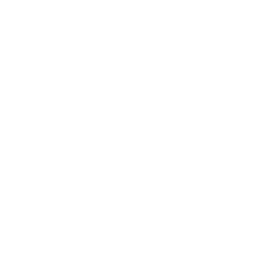

Reconstructed Images:


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 28>:29                                                                            │
│                                                                                                  │
│   26 print("Reconstructed Images:")                                                              │
│   27 recon_image_list = []                                                                       │
│   28 for _ in range(n_image_to_gen):                                                             │
│ ❱ 29 │   recon_images, _ = model.gen_image(1, num_iter=mage_steps, choice_temperature=mage_te    │
│   30 │   viz_torchimage(recon_images[0])                                                         │
│   31                                                                                             │
│                                                                                                  │
│ /home/nicoleg/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1614 in __getattr__  │
│                                                                                                  │
│   1611 │   │   │   modules = self.__dict__['_modules']                                           │
│   1612 │   │   │   if name in modules:                                                           │
│   1613 │   │   │   │   return modules[name]                                                      │
│ ❱ 1614 │   │   raise AttributeError("'{}' object has no attribute '{}'".format(                  │
│   1615 │   │   │   type(self).__name__, name))                                                   │
│   1616 │                                                                                         │
│   1617 │   def __setattr__(self, name: str, value: Union[Tensor, 'Module']) -> None:             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'RDM' object has no attribute 'gen_image'

In [13]:
n_image_to_gen = 1
rdm_steps = 250
rdm_eta = 1.0
mage_temp = 11.0
mage_steps = 20
cfg = 0.0

_, (images, _) = next(data_iterator)

images = images.cuda()
print("Ground Truth Image:")
viz_torchimage(images[0])

with torch.no_grad():
    mean = torch.Tensor([0.485, 0.456, 0.406]).cuda().unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
    std = torch.Tensor([0.229, 0.224, 0.225]).cuda().unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
    x_normalized = (images - mean) / std
    x_normalized = torch.nn.functional.interpolate(x_normalized, 224, mode='bicubic')
    rep = model.pretrained_encoder.forward_features(x_normalized)
    if model.pretrained_enc_withproj:
        rep = model.pretrained_encoder.head(rep)
    rep_std = torch.std(rep, dim=1, keepdim=True)
    rep_mean = torch.mean(rep, dim=1, keepdim=True)
    rep = (rep - rep_mean) / rep_std

print("Reconstructed Images:")
recon_image_list = []
for _ in range(n_image_to_gen):
    recon_images, _ = model.gen_image(1, num_iter=mage_steps, choice_temperature=mage_temp, sampled_rep=rep, rdm_steps=rdm_steps, eta=rdm_eta, cfg=cfg, class_label=None)
    viz_torchimage(recon_images[0])
